**Grid-Erstellung und Bar-Zonen für Köln**

- 500m Rastergrid über Köln
- Bars/Pubs/Nightclubs von OSM Overpass laden
- Zonen Kategorisierung nach Bar-Dichte (Barlos, Bararm, Barzone, Hotspot)
- Unfallmetriken pro Grid aggregieren



In [1]:
!pip install osmnx geopandas pyarrow -q

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import osmnx as ox
from shapely.geometry import box

### Daten laden
- Unfalldaten
- Bars/Pubs/Nightclubs/Biergärten/Brauereien über Overpass API für Köln

In [3]:
df_unfaelle = gpd.read_parquet("unfaelle_mit_strassen.parquet")

print(f"Unfälle geladen: {len(df_unfaelle)}")
print(f"CRS: {df_unfaelle.crs}")
df_unfaelle.head()

Unfälle geladen: 12488
CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "ETRS89 / UTM zone 32N", "base_crs": {"name": "ETRS89", "datum_ensemble": {"name": "European Terrestrial Reference System 1989 ensemble", "members": [{"name": "European Terrestrial Reference Frame 1989"}, {"name": "European Terrestrial Reference Frame 1990"}, {"name": "European Terrestrial Reference Frame 1991"}, {"name": "European Terrestrial Reference Frame 1992"}, {"name": "European Terrestrial Reference Frame 1993"}, {"name": "European Terrestrial Reference Frame 1994"}, {"name": "European Terrestrial Reference Frame 1996"}, {"name": "European Terrestrial Reference Frame 1997"}, {"name": "European Terrestrial Reference Frame 2000"}, {"name": "European Terrestrial Reference Frame 2005"}, {"name": "European Terrestrial Reference Frame 2014"}, {"name": "European Terrestrial Reference Frame 2020"}], "ellipsoid": {"name": "GRS 1980", "semi_major_axis": 6378137, "

,UJAHR,USTUNDE,UWOCHENTAG,UART,UTYP1,ULICHTVERH,IstRad,IstPKW,IstFuss,IstKrad,...,reversed,length,has_signal,has_crossing,has_sidewalk,has_parking,lanes_clean,maxspeed_clean,lanes_imputed,maxspeed_imputed
8479,2020,16,7,5,3,2,1,1,0,0,...,1.0,32.688545,0.0,1.0,1.0,1.0,NaN,30.0,1.0,30.0
310,2019,18,7,3,5,1,1,1,0,0,...,0.0,140.970879,1.0,1.0,1.0,1.0,2.0,30.0,2.0,30.0
3577,2019,16,1,8,7,0,0,0,0,0,...,0.0,113.568982,1.0,0.0,0.0,1.0,2.0,50.0,2.0,50.0
8696,2021,17,1,3,1,0,1,1,0,0,...,0.0,96.057830,1.0,1.0,0.0,1.0,2.0,30.0,2.0,30.0
7912,2020,10,2,5,2,0,1,1,0,0,...,0.0,142.650523,1.0,1.0,0.0,1.0,2.0,50.0,2.0,50.0


In [4]:
# OSM Relation ID 3600062578 = Köln
URL = "https://overpass-api.de/api/interpreter"

query = """
[out:json][timeout:90];

area(3600062578)->.searchArea;

(
  node["amenity"="bar"](area.searchArea);
  way["amenity"="bar"](area.searchArea);

  node["amenity"="pub"](area.searchArea);
  way["amenity"="pub"](area.searchArea);

  node["amenity"="nightclub"](area.searchArea);
  way["amenity"="nightclub"](area.searchArea);

  node["amenity"="biergarten"](area.searchArea);
  way["amenity"="biergarten"](area.searchArea);

  node["craft"="brewery"](area.searchArea);
  way["craft"="brewery"](area.searchArea);
);

out center;
"""

resp = requests.get(URL, params={"data": query})

records = []
for el in resp.json()["elements"]:
    tags = el.get("tags", {})
    if el["type"] == "node":
        lat, lon = el["lat"], el["lon"]
    else:
        lat, lon = el["center"]["lat"], el["center"]["lon"]

    records.append({
        "id": el["id"],
        "type": el["type"],
        "name": tags.get("name"),
        "amenity": tags.get("amenity"),
        "craft": tags.get("craft"),
        "lat": lat,
        "lon": lon
    })

df_bars = pd.DataFrame(records).drop_duplicates(subset=["name", "lat", "lon"])

print(f"Bars geladen: {len(df_bars)}")
df_bars.head()

Bars geladen: 627


,id,type,name,amenity,craft,lat,lon
0,54020544,node,Biergarten Rathenauplatz Veedelstreff,biergarten,None,50.931336,6.936973
1,186484750,node,Försterstube,pub,None,50.955347,6.922293
2,196186731,node,Fridolin-Eck,pub,None,50.954470,6.920768
3,196190188,node,Schäfer's Eck,pub,None,50.951854,6.924618
4,196191317,node,Müllers Ehrenfeld,pub,None,50.951599,6.925248


In [5]:
bars_gdf = gpd.GeoDataFrame(
    df_bars,
    geometry=gpd.points_from_xy(df_bars["lon"], df_bars["lat"]),
    crs="EPSG:4326"
).to_crs(25832)

if df_unfaelle.crs is None or str(df_unfaelle.crs) != "EPSG:25832":
    unfaelle_gdf = gpd.GeoDataFrame(
        df_unfaelle,
        geometry=gpd.points_from_xy(df_unfaelle["XGCSWGS84"], df_unfaelle["YGCSWGS84"]),
        crs="EPSG:4326"
    ).to_crs(25832)
else:
    unfaelle_gdf = df_unfaelle.copy()

print(f"Bars CRS: {bars_gdf.crs}, Unfälle CRS: {unfaelle_gdf.crs}")

Bars CRS: EPSG:25832, Unfälle CRS: EPSG:25832


### Rastergrid & Bar-Zonen
- 500m Zellen über Köln Boundary, zugeschnitten auf Stadtgrenze
- 150m Buffer beim Bar Count damit Bars am Rand der Zelle trotzdem mitzählen
- Zonen: 0 Bars = Barlos, 1-2 = Bararm, 3-9 = Barzone, 10+ = Hotspot

In [6]:
koeln_boundary = ox.geocode_to_gdf("Köln, Deutschland")[["geometry"]].to_crs(25832)
koeln_boundary = koeln_boundary.dissolve().set_geometry("geometry")

minx, miny, maxx, maxy = koeln_boundary.total_bounds

xs = np.arange(minx, maxx, 500)
ys = np.arange(miny, maxy, 500)

grid = gpd.GeoDataFrame(
    geometry=[box(x, y, x + 500, y + 500) for x in xs for y in ys],
    crs=koeln_boundary.crs
)

grid_500 = gpd.overlay(grid, koeln_boundary, how="intersection")  # Zellen außerhalb Kölns abschneiden
grid_500["GridID"] = np.arange(len(grid_500))

print(f"Grid: {len(grid_500)} Zellen, CRS: {grid_500.crs}")

Grid: 1770 Zellen, CRS: EPSG:25832


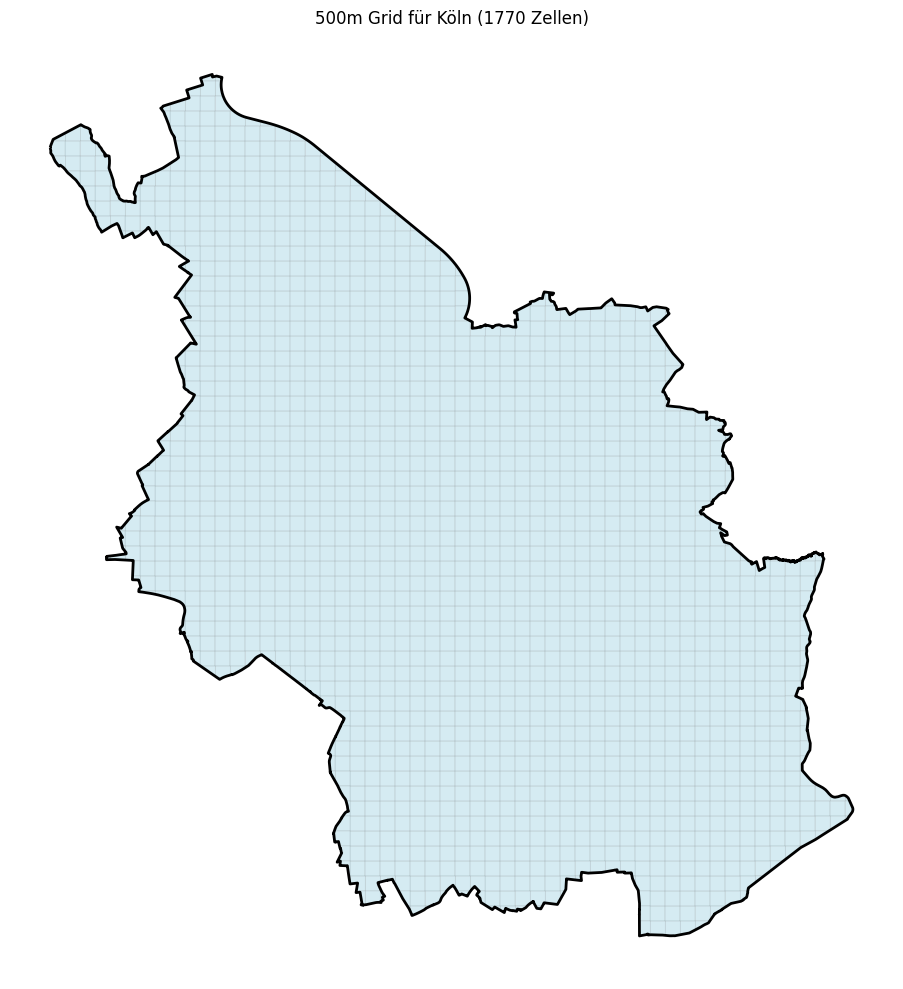

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_500.plot(ax=ax, linewidth=0.2, edgecolor='gray', facecolor='lightblue', alpha=0.5)
koeln_boundary.boundary.plot(ax=ax, linewidth=2, color='black')
ax.set_title(f"500m Grid für Köln ({len(grid_500)} Zellen)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [8]:
grid_500_buf = grid_500[["GridID", "geometry"]].copy()
grid_500_buf["geometry"] = grid_500_buf.geometry.buffer(150) # Bars am Rand der Zelle sollen trotzdem zählen

join = gpd.sjoin(
    bars_gdf[["geometry"]],
    grid_500_buf,
    how="left",
    predicate="within"
)

bar_counts = join.groupby("GridID").size()
grid_500["bar_count"] = grid_500["GridID"].map(bar_counts).fillna(0).astype(int)

print(grid_500["bar_count"].describe())
print(f"Zellen ohne Bars: {(grid_500['bar_count'] == 0).sum()} ({(grid_500['bar_count'] == 0).mean()*100:.1f}%)")

count    1770.000000
mean        0.872881
std         3.862562
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        66.000000
Name: bar_count, dtype: float64
Zellen ohne Bars: 1363 (77.0%)


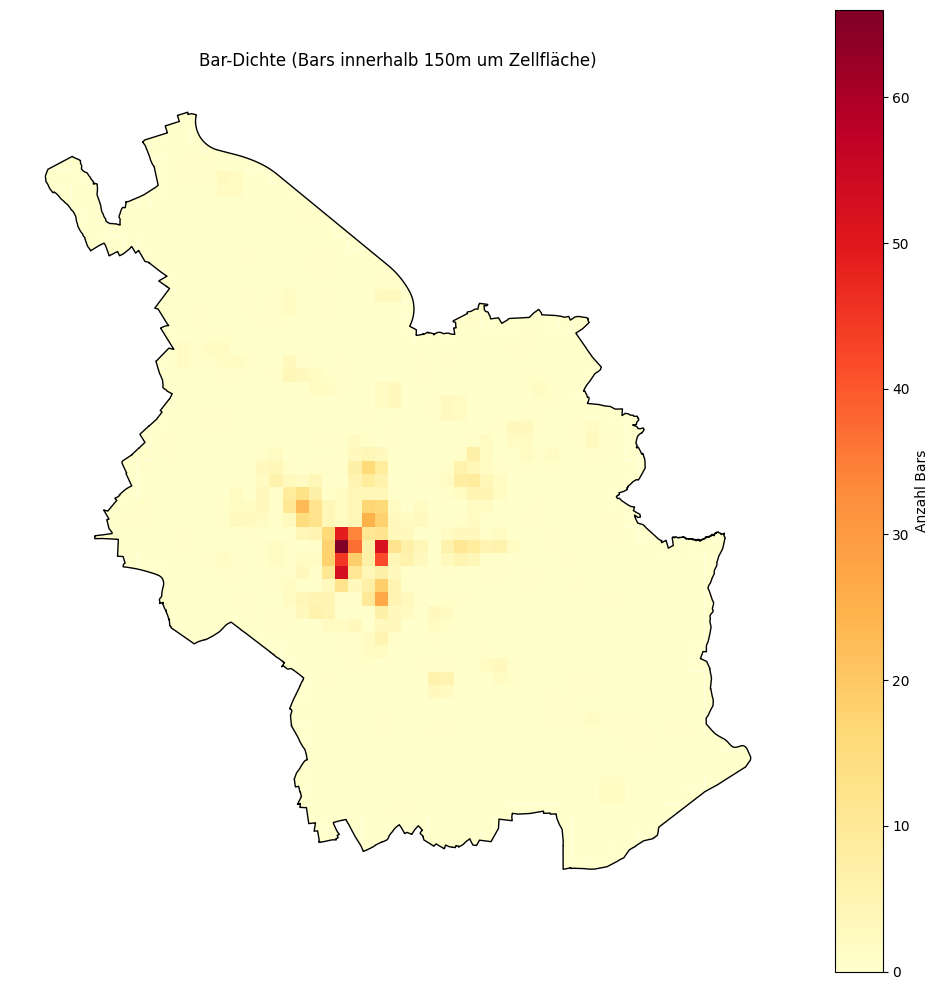

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_500.plot(column="bar_count", ax=ax, legend=True, cmap='YlOrRd',
              legend_kwds={'label': 'Anzahl Bars'})
koeln_boundary.boundary.plot(ax=ax, linewidth=1, color='black')
ax.set_title("Bar-Dichte (Bars innerhalb 150m um Zellfläche)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [11]:
grid_500["ZoneType_4"] = pd.cut(
    grid_500["bar_count"],
    bins=[-1, 0, 2, 9, 10**9], # -1 damit 0 Bars noch erfasst wird
    labels=["Barlos", "Bararm", "Barzone", "Hotspot"]
).astype('category')

print(grid_500["ZoneType_4"].value_counts())
print()
print(grid_500["ZoneType_4"].value_counts(normalize=True).round(3))

ZoneType_4
Barlos     1363
Bararm      277
Barzone      97
Hotspot      33
Name: count, dtype: int64

ZoneType_4
Barlos     0.770
Bararm     0.156
Barzone    0.055
Hotspot    0.019
Name: proportion, dtype: float64


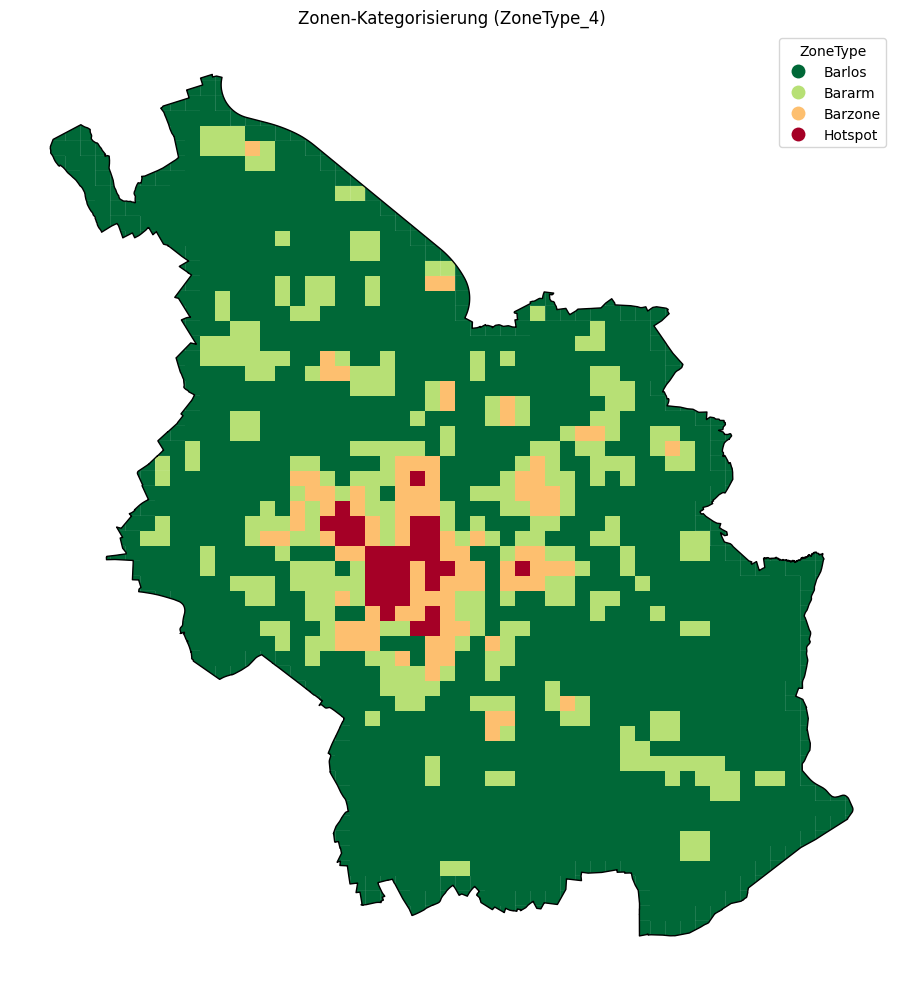

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_500.plot(column="ZoneType_4", ax=ax, legend=True, categorical=True,
              cmap='RdYlGn_r', legend_kwds={'title': 'ZoneType'})
koeln_boundary.boundary.plot(ax=ax, linewidth=1, color='black')
ax.set_title("Zonen-Kategorisierung (ZoneType_4)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Unfallmetriken
- EN = Abend/Nacht (Abend, Spätabend, Nacht)
- Differenz zeigt ob ein Grid nachts mehr Unfälle hat als tagsüber

In [13]:
unfaelle_in_grid = gpd.sjoin(
    unfaelle_gdf,
    grid_500[['GridID', 'geometry']],
    how='left',
    predicate='within'
)

unfaelle_in_grid['is_EN'] = unfaelle_in_grid['ZeitKategorie'].isin(
    ['Abend', 'Spätabend', 'Nacht']
).astype(int) # EN = Evening/Night

unfaelle_in_grid['is_day'] = unfaelle_in_grid['ZeitKategorie'].isin(
    ['Tag', 'Morgen']
).astype(int)

print(f"Unfälle mit Grid: {unfaelle_in_grid['GridID'].notna().sum()} / {len(unfaelle_in_grid)}")

Unfälle mit Grid: 12459 / 12488


In [14]:
grid_metrics = unfaelle_in_grid.groupby('GridID').agg(
    Acc_total=('GridID', 'size'),
    Acc_EN=('is_EN', 'sum'),
    Acc_day=('is_day', 'sum'),
    Acc_severe=('UKATEGORIE_Name', lambda x: x.isin(
        ['Unfall mit Getöteten', 'Unfall mit Schwerverletzten']
    ).sum())
).reset_index()

grid_metrics['Delta_ENvsDay'] = grid_metrics['Acc_EN'] - grid_metrics['Acc_day']  # positiv = mehr nachts

grid_500 = grid_500.merge(grid_metrics, on='GridID', how='left')

fill_cols = ['Acc_total', 'Acc_EN', 'Acc_day', 'Acc_severe', 'Delta_ENvsDay']
grid_500[fill_cols] = grid_500[fill_cols].fillna(0)  # Grids ohne Unfälle -> 0 statt NaN

grid_500[['GridID', 'bar_count', 'ZoneType_4', 'Acc_total', 'Acc_EN', 'Acc_severe']].describe()

,GridID,bar_count,Acc_total,Acc_EN,Acc_severe
count,1770.000000,1770.000000,1770.000000,1770.000000,1770.000000
mean,884.500000,0.872881,7.038983,2.452542,1.115819
std,511.099305,3.862562,13.102637,5.368423,2.099457
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,442.250000,0.000000,0.000000,0.000000,0.000000
50%,884.500000,0.000000,2.000000,0.000000,0.000000
75%,1326.750000,0.000000,8.000000,3.000000,1.000000
max,1769.000000,66.000000,131.000000,75.000000,20.000000


In [15]:
grid_clean = grid_500[[
    'geometry', 'GridID', 'bar_count', 'ZoneType_4',
    'Acc_total', 'Acc_EN', 'Acc_day', 'Acc_severe', 'Delta_ENvsDay'
]].copy()

stats_by_zone = grid_clean.groupby('ZoneType_4').agg({
    'GridID': 'count',
    'bar_count': 'mean',
    'Acc_total': 'sum',
    'Acc_EN': 'sum',
    'Acc_severe': 'sum'
}).rename(columns={'GridID': 'n_cells'})

stats_by_zone['Acc_EN_share'] = stats_by_zone['Acc_EN'] / stats_by_zone['Acc_total'] # Nachtanteil pro Zone
stats_by_zone['Acc_per_cell'] = stats_by_zone['Acc_total'] / stats_by_zone['n_cells']

stats_by_zone.round(2)

/tmp/ipython-input-4133749479.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_by_zone = grid_clean.groupby('ZoneType_4').agg({


,n_cells,bar_count,Acc_total,Acc_EN,Acc_severe,Acc_EN_share,Acc_per_cell
ZoneType_4,,,,,,,
Barlos,1363,0.00,4874.0,1551.0,868.0,0.32,3.58
Bararm,277,1.27,3129.0,1032.0,503.0,0.33,11.30
Barzone,97,4.44,2484.0,894.0,350.0,0.36,25.61
Hotspot,33,23.12,1972.0,864.0,254.0,0.44,59.76


### Export

In [16]:
grid_clean.to_parquet("grid_with_zones.parquet")

print(f"grid_with_zones.parquet: {len(grid_clean)} Zeilen, {len(grid_clean.columns)} Spalten")

grid_with_zones.parquet: 1770 Zeilen, 9 Spalten
